# "[RNN] RNN"
> "주가 예측하기"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [DL, Pytorch, CNN, U-Net]
- author: 도형준


# 주가 예측하기

## 데이터 적재

In [49]:
!pip install yfinance --quiet

In [50]:
import yfinance as yf

In [51]:
history = yf.Ticker('NFLX').history(period='max')
history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-05-23 00:00:00-04:00,1.156429,1.242857,1.145714,1.196429,104790000,0,0.0
2002-05-24 00:00:00-04:00,1.214286,1.225000,1.197143,1.210000,11104800,0,0.0
2002-05-28 00:00:00-04:00,1.213571,1.232143,1.157143,1.157143,6609400,0,0.0
2002-05-29 00:00:00-04:00,1.164286,1.164286,1.085714,1.103571,6757800,0,0.0
2002-05-30 00:00:00-04:00,1.107857,1.107857,1.071429,1.071429,10154200,0,0.0


In [52]:
# 2015-01-01 ~ 2020-12-31
# Date, Open, High, Low, Volume, Close만 호출 예정
history.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [53]:
# Date 인덱스에서 추출
history.reset_index(inplace=True)
history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-05-23 00:00:00-04:00,1.156429,1.242857,1.145714,1.196429,104790000,0,0.0
1,2002-05-24 00:00:00-04:00,1.214286,1.225000,1.197143,1.210000,11104800,0,0.0
2,2002-05-28 00:00:00-04:00,1.213571,1.232143,1.157143,1.157143,6609400,0,0.0
3,2002-05-29 00:00:00-04:00,1.164286,1.164286,1.085714,1.103571,6757800,0,0.0
4,2002-05-30 00:00:00-04:00,1.107857,1.107857,1.071429,1.071429,10154200,0,0.0


In [54]:
# 시간 없애고 날짜만 남기기
# dt.date => str (문자열)
# 시간을 없애고 -> datetime => date (시간 X) => date()
import pandas as pd

history.Date = pd.to_datetime(history.Date.dt.date)
history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000,0,0.0
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800,0,0.0
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400,0,0.0
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800,0,0.0
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200,0,0.0


In [55]:
history.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)
history.head()

,Date,Open,High,Low,Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200


In [56]:
# between (A, B) 날짜만 표시
df = history[history['Date'].between('2015-01-01', '2018-12-31')
].reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-02,49.151428,50.331429,48.731430,49.848572,13475000
1,2015-01-05,49.258572,49.258572,47.147144,47.311428,18165000
2,2015-01-06,47.347141,47.639999,45.661430,46.501431,16037700
3,2015-01-07,47.347141,47.421429,46.271427,46.742859,9849700
4,2015-01-08,47.119999,47.835712,46.478573,47.779999,9601900


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


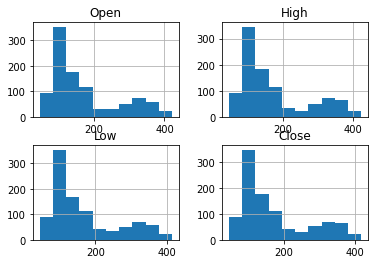

In [57]:
# 시간 순서대로 주가를 분석해서 -> 다음날의 종가(Close)를 예측
# 입력 -> Open(개장가) High(최고가) Low(최저가) => 정답데이터 종가
import matplotlib.pyplot as plt

df_used = df[['Open', 'High', 'Low']]
df_used['Close'] = df['Close']
hist = df_used.hist()
plt.show()

## Dataset 학습용 데이터셋 (Netflix)

In [58]:
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        # 데이터 정규화
        self.data = df_used.drop('Close', axis=1).values # 값만 있는 배열
        self.data = self.data / np.max(self.data) # np.max 배열에서 가장 큰 값

        self.label = df_used['Close'].values
        self.label = self.label / np.max(self.label)
    
    # 사용가능한 배치 개수를 반환하는 __len__()
    def __len__(self):
        return len(self.data) - 30 # 사용가능한 배치 계수
        # 30일치가 묶여서 batch 

    # 30일치 데이터를 읽어오는 함수
    def __getitem__(self, i): # 0 ~ len-1
        data = self.data[i:i+30] # 입력데이터(시가,고가,저가,날짜)
        label = self.label[i+30] # 종가
        return data, label

## RNN 모델 정의

In [59]:
#@title RNN 모델 정의

import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        # RNN 층 정의
        # Open, High, Low
        self.rnn = nn.RNN(input_size=3, hidden_size=8,
                          num_layers=5, # RNN층을 얼마나 쌓을까? 3? 5?
                          # 너무 많으면 기울기 소실, 너무 적으면 기울기 폭발
                          batch_first=True) # Batch 차원 (30, 8)
        # FC, MLP => 분류, 예측
        # 주가를 예측하는 MLP층 정의
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.ReLU()
    
    def forward(self, x, h0):
        x, hn = self.rnn(x, h0) # RNN층의 출력
        # x -> 층을 거쳐 나온 결과 (출력층) / hn은 모든 RNN층의 은닉 상태 (누적 가중치)
        # 2차원 -> 1차원... (MLP층의 입력으로 사용되게 모양 변경)
        x = torch.reshape(x, (x.shape[0], -1))

        # MLP 층을 사용해서 값 예측
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # 출력층
        x = torch.flatten(x)

        return x

## 모델 학습

In [60]:
from tqdm.notebook import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else "cpu"

model = RNN().to(device)
dataset = Netflix()

In [61]:
loader = DataLoader(dataset, batch_size=32)

In [62]:
optim = Adam(params=model.parameters(), lr=0.0001)

## 학습 루프

In [63]:
for epoch in range(200):
    iterator = tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        # 초기 은닉 상태
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        # 모델의 예측값
        preds = model(data.type(torch.FloatTensor).to(device), h0)
        # 손실 계산
        loss = nn.MSELoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward() # 역전파
        optim.step() # 최적화

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

## 모델 성능 평가하기

In [65]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # ➊초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  # ➋예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # ➌손실의 평균치 계산

total_loss.item()

0.003371224505826831

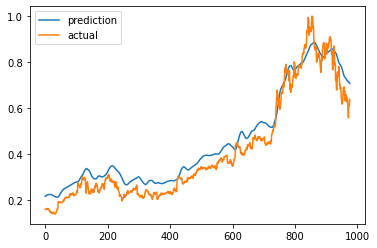

In [66]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()